# NER for constructing KG

In [1]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 7.2 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 7.8 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 7.9 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 8.1 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 8.3 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 8.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 8.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## EDA and preprocessing CoNLLu04


In this experiment will be used [CoNLLU04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations (Located_In, Work_For, OrgBased_In, Live_In, Kill), and corresponding texts. The data is primarily based on news articles. The original dataset can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [2]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm
!pip install sklearn_crfsuite

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from datasets import load_dataset
dataset = load_dataset("DFKI-SLT/conll04")

c:\Users\Apple\Desktop\NER for KG\NER_for_KG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset has already contained data for training, validation and testing. Let's convert all JSON data in DataFrame.

In [4]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

,entities,tokens,relations,orig_id
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210


The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

In [7]:
print("Training samples:", len(df_train))
print("Test samples:", len(df_test))

Training samples: 922
Test samples: 288


#### Texts and tokens

In [8]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

,entities,tokens,relations,orig_id,texts
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...


Examples of texts

In [9]:
for i in df_train['texts'].head(5):
  print(i)

Newspaper ` Explains ' U.S. Interests Section Events FL1402001894 Havana Radio Reloj Network in Spanish 2100 GMT 13 Feb 94
` ` If it does not snow , and a lot , within this month we will have no water to submerge 150 , 000 hectares ( 370 , 500 acres ) of rice , ' ' said Bruno Pusterla , a top official of the Italian Agricultural Confederation .
The self-propelled rig Avco 5 was headed to shore with 14 people aboard early Monday when it capsized about 20 miles off the Louisiana coast , near Morgan City , Lifa said.
Annie Oakley , also known as Little Miss Sure Shot , was born Phoebe Ann Moses in Willowdell , Darke County , in 1860 .
Penry raped Pamela Moseley Carpenter on Oct. 15 , 1979 , in Livingston , Texas , then stabbed her to death .


Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


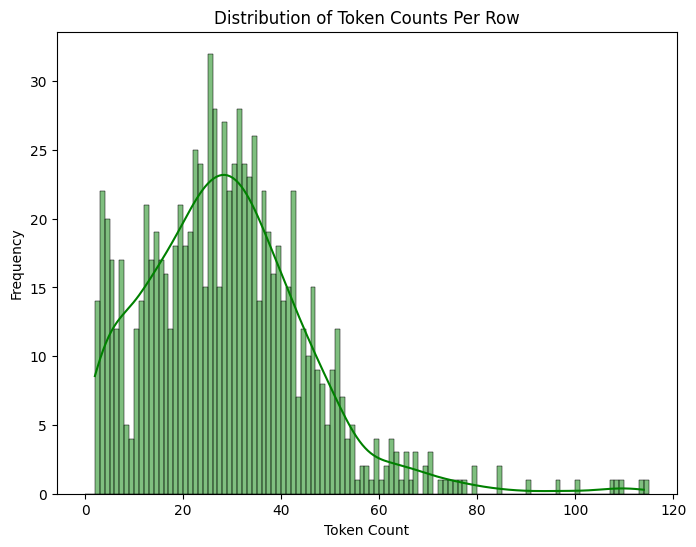

In [10]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=True, color='green')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


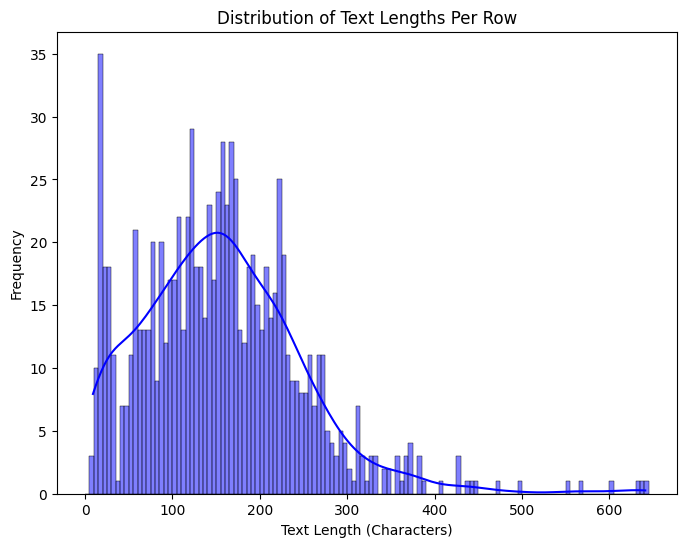

In [11]:
text_lengths = [len(text) for text in df_train['texts']]
total_text_length = sum(text_lengths)
average_text_length = sum(text_lengths) / len(text_lengths)

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=True, color='blue')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [12]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [13]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter..."
...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ..."


In [14]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] += 1
    return categories

In [15]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

C:\Users\Apple\AppData\Local\Temp\ipykernel_17952\3761919945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


,orig_id,named_entities,entity_categories
0,3255,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...","{'Peop': 0, 'Loc': 2, 'Org': 1, 'Other': 2}"
1,95,"[150 , 000 hectares (22, 26) : Other, 370 , 50...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 3}"
2,2447,"[20 miles (19, 21) : Other, Louisiana (23, 24)...","{'Peop': 1, 'Loc': 2, 'Org': 0, 'Other': 1}"
3,5284,"[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","{'Peop': 3, 'Loc': 1, 'Org': 0, 'Other': 0}"
4,210,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...","{'Peop': 2, 'Loc': 2, 'Org': 0, 'Other': 1}"
...,...,...,...
917,5423,"[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}"
918,1269,"[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}"
919,4136,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","{'Peop': 1, 'Loc': 2, 'Org': 1, 'Other': 0}"
920,1452,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}"


In [16]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

,orig_id,Peop,Loc,Org,Other
0,3255,0,2,1,2
1,95,1,0,1,3
2,2447,1,2,0,1
3,5284,3,1,0,0
4,210,2,2,0,1
...,...,...,...,...,...
917,5423,1,1,1,1
918,1269,1,0,1,0
919,4136,1,2,1,0
920,1452,0,1,1,0


Plot a bar chart

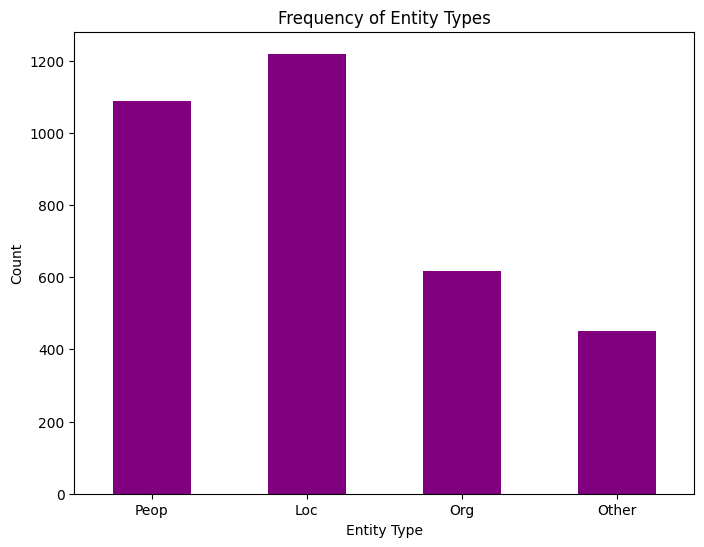

In [17]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['purple'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Triplets

In [18]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]

        head_text = head_entity_str.split(' (', 1)[0].strip()
        tail_text = tail_entity_str.split(' (', 1)[0].strip()

        triplet = f"{head_text}|{rel_type}|{tail_text}"
        triplets.append(triplet)
    return triplets

In [19]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train['triplet_count'] = df_train['triplets'].apply(len)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],1
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,1
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],1
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...",3
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],1
...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],1
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],1
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,2
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],1


Plot the distribution of triplets

Total number of triplets in the dataset: 1283


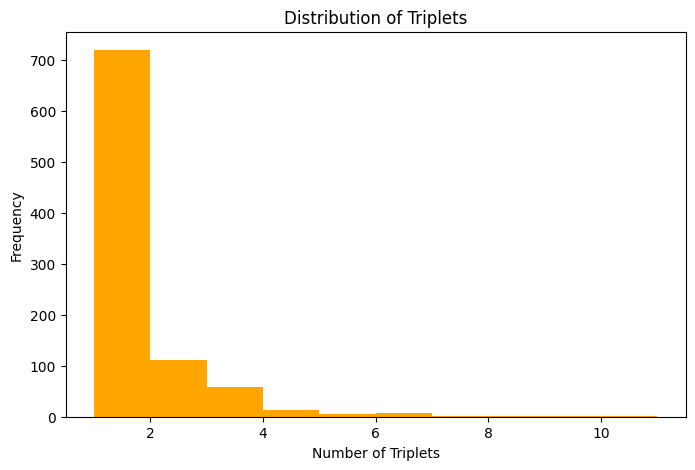

In [20]:
total_triplets = df_train['triplet_count'].sum()
print(f"Total number of triplets in the dataset: {total_triplets}")

plt.figure(figsize=(8, 5))
plt.hist(df_train['triplet_count'], bins=range(1, 12), color='orange')
plt.title("Distribution of Triplets")
plt.xlabel("Number of Triplets")
plt.ylabel("Frequency")
plt.show()

## Classical ML Method for NER task: Conditional Random Fields (CRF)

CRF is a discriminative probabilistic model designed for sequence labeling tasks like NER. Unlike generative models (e.g., Hidden Markov Models), CRFs directly model the conditional probability P(Y∣X), where Y is the label sequence and X is the input sequence. This allows CRFs to leverage complex feature interactions and avoid the label bias problem. More info about CRF: [[Lafferty et al.2001]](https://www.researchgate.net/publication/2529190_Conditional_Random_Fields_Probabilistic_Models_for_Segmenting_and_Labeling_Sequence_Data)

The conditional probability of a label sequence \( Y = (y_1, y_2, ..., y_n) \) given an input sequence \( X = (x_1, x_2, ..., x_n) \) is defined as:

$$P(Y|X; \theta) = \frac{1}{Z(X)} \exp \left( \sum_{i=1}^n \sum_k \theta_k^{(s)} f_k^{(s)}(y_i, x_i, i) + \sum_{i=1}^{n-1} \sum_k \theta_k^{(t)} f_k^{(t)}(y_i, y_{i+1}, x_i, x_{i+1}, i) \right)$$


Where:
- theta: Parameters (feature weights) learned during training
- Z(X): Normalization term (partition function), ensuring probabilities sum to 1
- f^(s): State (vertex) features which are associated with individual positions *i* and labels *y_i*
- f^(t): Transition (edge) features which are associated with transitions between labels *y_i* and *y_(i+1)*

In the experiment parameters from [this article](https://arxiv.org/pdf/1404.5367#page=3.43) was used:
- State features:
  - bias
  - POS
  - lower-case
  - its capitalization pattern;
  - whether it is punctuation
  - 4-character prefixes and suffixes;
  - character n-grams from length 2 to 5;

<b> + Neighborhood features </b>

- Transition features: bio-tagging tokens with named entities (features are specified through CRF model hyperparameters)

Let's modify current dataset and prepare data for training

### Extracting token features

In [21]:
def add_pos_tags(row):
    tokens = row['tokens']
    doc = nlp(' '.join(tokens))
    pos_tags = [token.pos_ for token in doc]

    row['pos_tags'] = pos_tags
    return row

In [22]:
df_train = df_train.apply(add_pos_tags, axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count,pos_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],1,"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,1,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],1,"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...",3,"[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],1,"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,..."
...,...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],1,"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],1,"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,2,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],1,"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P..."


In [23]:
def get_char_ngrams(token, min_n=2, max_n=5):
    ngrams = set()
    for n in range(min_n, max_n+1):
        for i in range(len(token) - n + 1):
            ngrams.add(token[i:i+n])
    return ngrams

In [24]:
def extract_features(df_row, i):
    tokens = df_row['tokens']
    pos_tags = df_row['pos_tags']

    token = tokens[i]
    pos = pos_tags[i]

    features = {
        'bias': 1.0,
        'pos': pos,
        'word.lower()': token.lower(),
        'is_capitalized': token[0].isupper() if len(token) > 0 else False,
        'is_all_caps': token.isupper(),
        'word.is_punctuation': token in ['.', ',', ';', '?', '!'],
        'prefix4': token[:4] if len(token) >= 4 else token,
        'suffix4': token[-4:] if len(token) >= 4 else token,
        'char_ngrams': get_char_ngrams(token),
    }

    # Neighborhood features
    if i > 0:
        prev_token = tokens[i-1]
        prev_pos = pos_tags[i-1]
        features.update({
            '-1:word.lower()': prev_token.lower(),
            '-1:pos': prev_pos if len(prev_pos) >= 2 else prev_pos,
        })
    else:
        features['BOS'] = True

    if i < len(tokens) - 1:
        next_token = tokens[i+1]
        next_pos = pos_tags[i+1]
        features.update({
            '+1:word.lower()': next_token.lower(),
            '+1:pos': next_pos if len(next_pos) >= 2 else next_pos,
        })
    else:
        features['EOS'] = True

    return features

### BIO-tagging

In [25]:
def generate_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for entity in entities:
        start = entity['start']
        end = entity['end']
        typ = entity['type']
        if start < len(bio_tags):
            bio_tags[start] = f'B-{typ}'
        for i in range(start + 1, end):
            if i < len(bio_tags):
                bio_tags[i] = f'I-{typ}'
    return bio_tags

In [26]:
df_train['bio_tags'] = df_train.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count,pos_tags,bio_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],1,"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN...","[O, O, O, O, B-Loc, O, O, O, O, B-Loc, B-Org, ..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,1,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],1,"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...",3,"[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P...","[B-Peop, I-Peop, O, O, O, O, B-Peop, I-Peop, I..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],1,"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,...","[B-Peop, O, B-Peop, I-Peop, I-Peop, O, B-Other..."
...,...,...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],1,"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,...","[B-Other, O, O, O, O, O, O, O, O, O, O, O, O, ..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],1,"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ...","[O, B-Org, O, O, O, B-Peop, I-Peop, I-Peop, O,..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,2,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET...","[O, O, O, O, O, O, O, O, B-Loc, O, O, O, B-Peo..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],1,"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P...","[B-Org, I-Org, O, O, B-Loc, O, O, O]"


## Training

In [27]:
def sent2features(df_row):
    tokens = df_row['tokens']
    return [extract_features(df_row, i) for i in range(len(tokens))]

def sent2labels(df_row):
    return df_row['bio_tags']

In [28]:
X_train = df_train.apply(sent2features, axis=1).tolist()
y_train = df_train.apply(sent2labels, axis=1).tolist()

In [37]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=50,
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=50)

Let's preprocess test data for evaluating results

In [38]:
df_test['bio_tags'] = df_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_test = df_test.apply(add_pos_tags, axis=1)

In [39]:
X_test = df_test.apply(sent2features, axis=1).tolist()
y_test = df_test.apply(sent2labels, axis=1).tolist()

y_pred = crf.predict(X_test)

## Evaluating

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV

In [40]:
y_test_flat = [label for sentence in y_test for label in sentence]
y_pred_flat = [label for sentence in y_pred for label in sentence]

labels = list(crf.classes_)


report_dict = classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4, output_dict=True)

print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4))

Classification Report:
              precision    recall  f1-score   support

           O     0.9692    0.9781    0.9737      6313
       B-Loc     0.8682    0.8173    0.8420       427
       B-Org     0.8045    0.7273    0.7639       198
       I-Org     0.6920    0.7925    0.7389       241
     B-Other     0.7981    0.6241    0.7004       133
     I-Other     0.8155    0.6462    0.7210       130
      B-Peop     0.8116    0.8318    0.8215       321
      I-Peop     0.8471    0.9458    0.8937       369
       I-Loc     0.8375    0.6569    0.7363       204

    accuracy                         0.9328      8336
   macro avg     0.8271    0.7800    0.7990      8336
weighted avg     0.9323    0.9328    0.9316      8336



In [41]:
micro_f1 = f1_score(y_test_flat, y_pred_flat, average='micro')

print(f"micro-F1: {micro_f1:.4f}")

micro-F1: 0.9328


Plot the confusion matrix

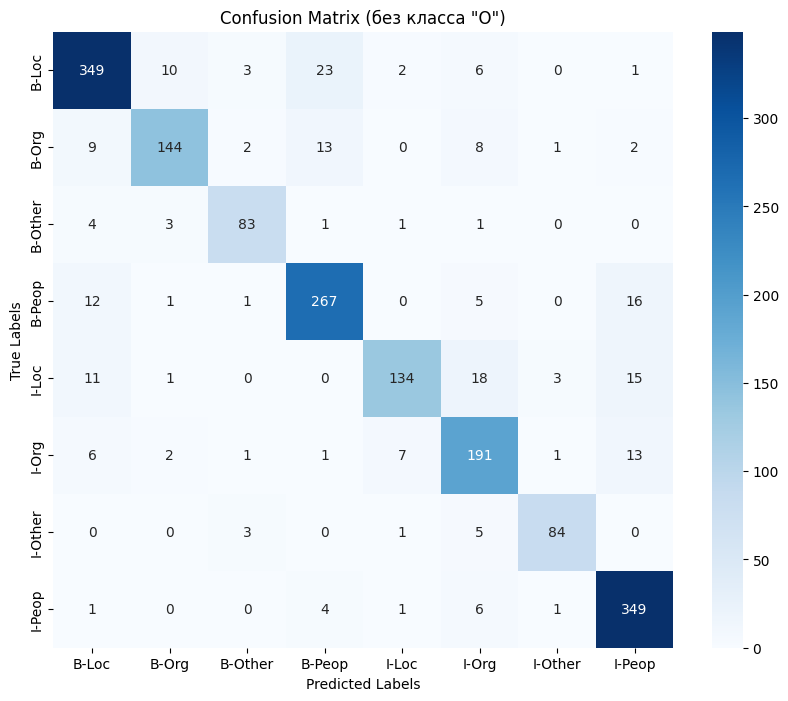

In [42]:
filtered_true = []
filtered_pred = []
for true_tag, pred_tag in zip(y_test_flat, y_pred_flat):
    if true_tag != 'O':
        filtered_true.append(true_tag)
        filtered_pred.append(pred_tag)

labels = list(set(tag for sent in y_test for tag in sent if tag != 'O'))
labels.sort()

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (без класса "O")')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Visualizing

Let's provide vizualization of extracted NERS

In [54]:
from IPython.display import display, HTML
import random

def visualize_example(tokens, true_tags, pred_tags):
    html = []
    for token, true_tag, pred_tag in zip(tokens, true_tags, pred_tags):
        if pred_tag != 'O':
            html.append(f'<mark style="background-color: orange; color:black">{token}</mark>')  
        else:
            html.append(token)
        html.append(f' ({true_tag}/{pred_tag}) ')
    return ''.join(html)

In [55]:
for _ in range(3):
    random_index = random.randint(0, len(df_test)-1)
    example = df_test.iloc[random_index]
    X_example = [sent2features(example)]
    y_pred_example = crf.predict(X_example)[0]
    display(HTML(visualize_example(
        example['tokens'],
        example['bio_tags'],
        y_pred_example
    )))

Let's build a knoweledge graph with extracted NERs

In [52]:
! pip install networkx

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 1.2 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.2 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.5 MB/s eta 0:00:00
